****
# PART 1
## Exploratory data analysis
****

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('seaborn-whitegrid')

In [3]:
df = pd.read_json('logins.json')
df['login_time'] = df['login_time'].sort_values()

# Data quality issues
The login times are not logged in chronological order. This requires an additional ordering step and introduces the potential for error.

In [4]:
df = df.set_index('login_time')
df['logins'] = 1

# Aggregation
The following aggregation converts the irregular time series into a fixed frequency time series of 15 minutes.

## Notes:
```python
week_df = df_15min_span.groupby(df_15min_span['logins'].index.weekday_name).mean()
```
does not give the desired output. This is the average 15 min login value across each day. The desired output is the average number of total logins per weekday.
- A combination of resamplings will be used instead.

In [5]:
df_15min_span = df.resample('15min').count()

In [6]:
df_day_span = df.resample('1D').count()

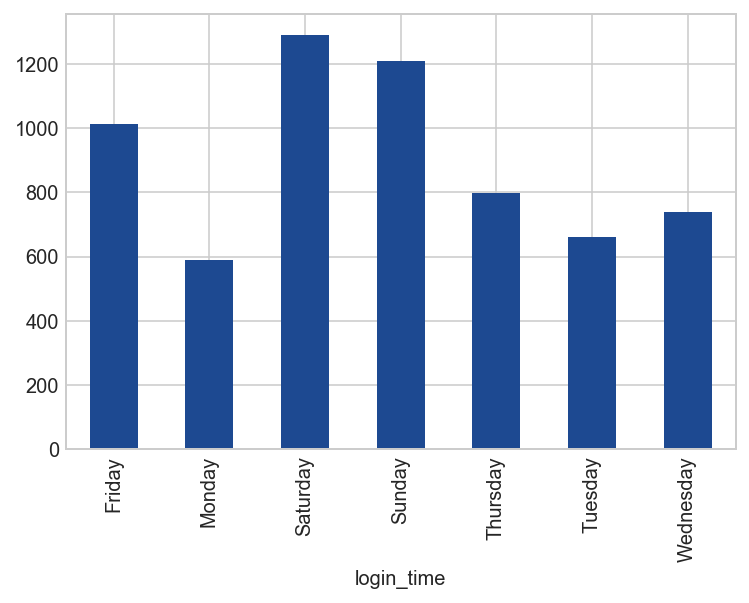

In [7]:
week_df = df_day_span.groupby(df_day_span['logins'].index.weekday_name).mean()
week_df['logins'].plot(kind='bar', color='#1d4991')

In [8]:
df_hour_span = df.resample('1H').count()

In [9]:
df_hour_span['weekday'] = list(df_hour_span.index.dayofweek)

In [10]:
df_weekdays = df_hour_span[df_hour_span['weekday'].isin([0,1,2,3,4])]
weekday_series = df_weekdays['logins']

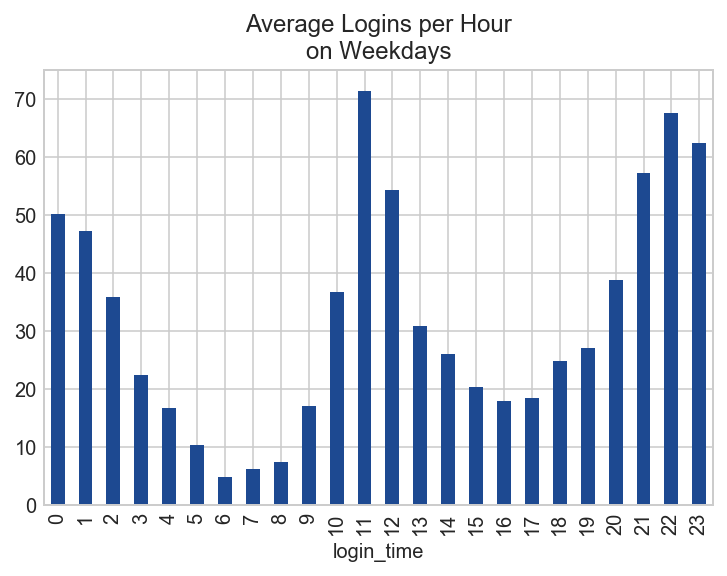

In [11]:
weekday_series.groupby(weekday_series.index.hour).mean().plot(kind='bar', 
                                                                title='Average Logins per Hour\non Weekdays',
                                                                color='#1d4991')

In [12]:
df_weekends = df_hour_span[df_hour_span['weekday'].isin([5,6])]
series_weekends = df_weekends['logins']

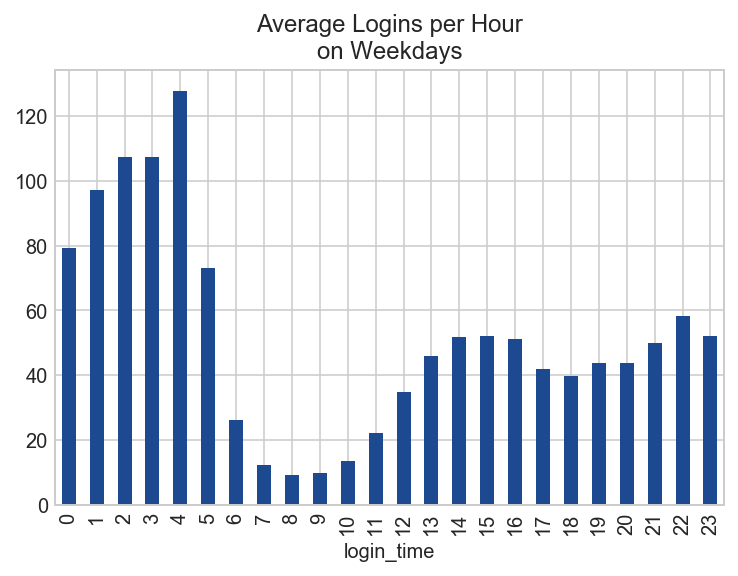

In [13]:
series_weekends.groupby(series_weekends.index.hour).mean().plot(kind='bar', 
                                                                title='Average Logins per Hour\non Weekdays',
                                                                color='#1d4991')

In [14]:
from datetime import timedelta, datetime

In [15]:
def plot_one_week(start_date):
    plt.figure(figsize=(14,14))
    for day in range(1,8):
        plot_date = str(datetime.strptime(start_date, '%Y-%m-%d') + (timedelta(day - 1)))[:11]
        plt.subplot(3,3,day)
        plt.plot(df_15min_span[plot_date]['logins'])
        plt.xticks([plot_date + '01:00:00', plot_date + '12:00:00', plot_date + '23:00:00'], 
                   ['1AM', 'Noon', '11PM'])
        plt.title('Logins for ' + datetime.strftime(datetime.strptime(start_date, '%Y-%m-%d') + (timedelta(day - 1)), 
                                                    '%A %B, %d %Y'))
    plt.show()

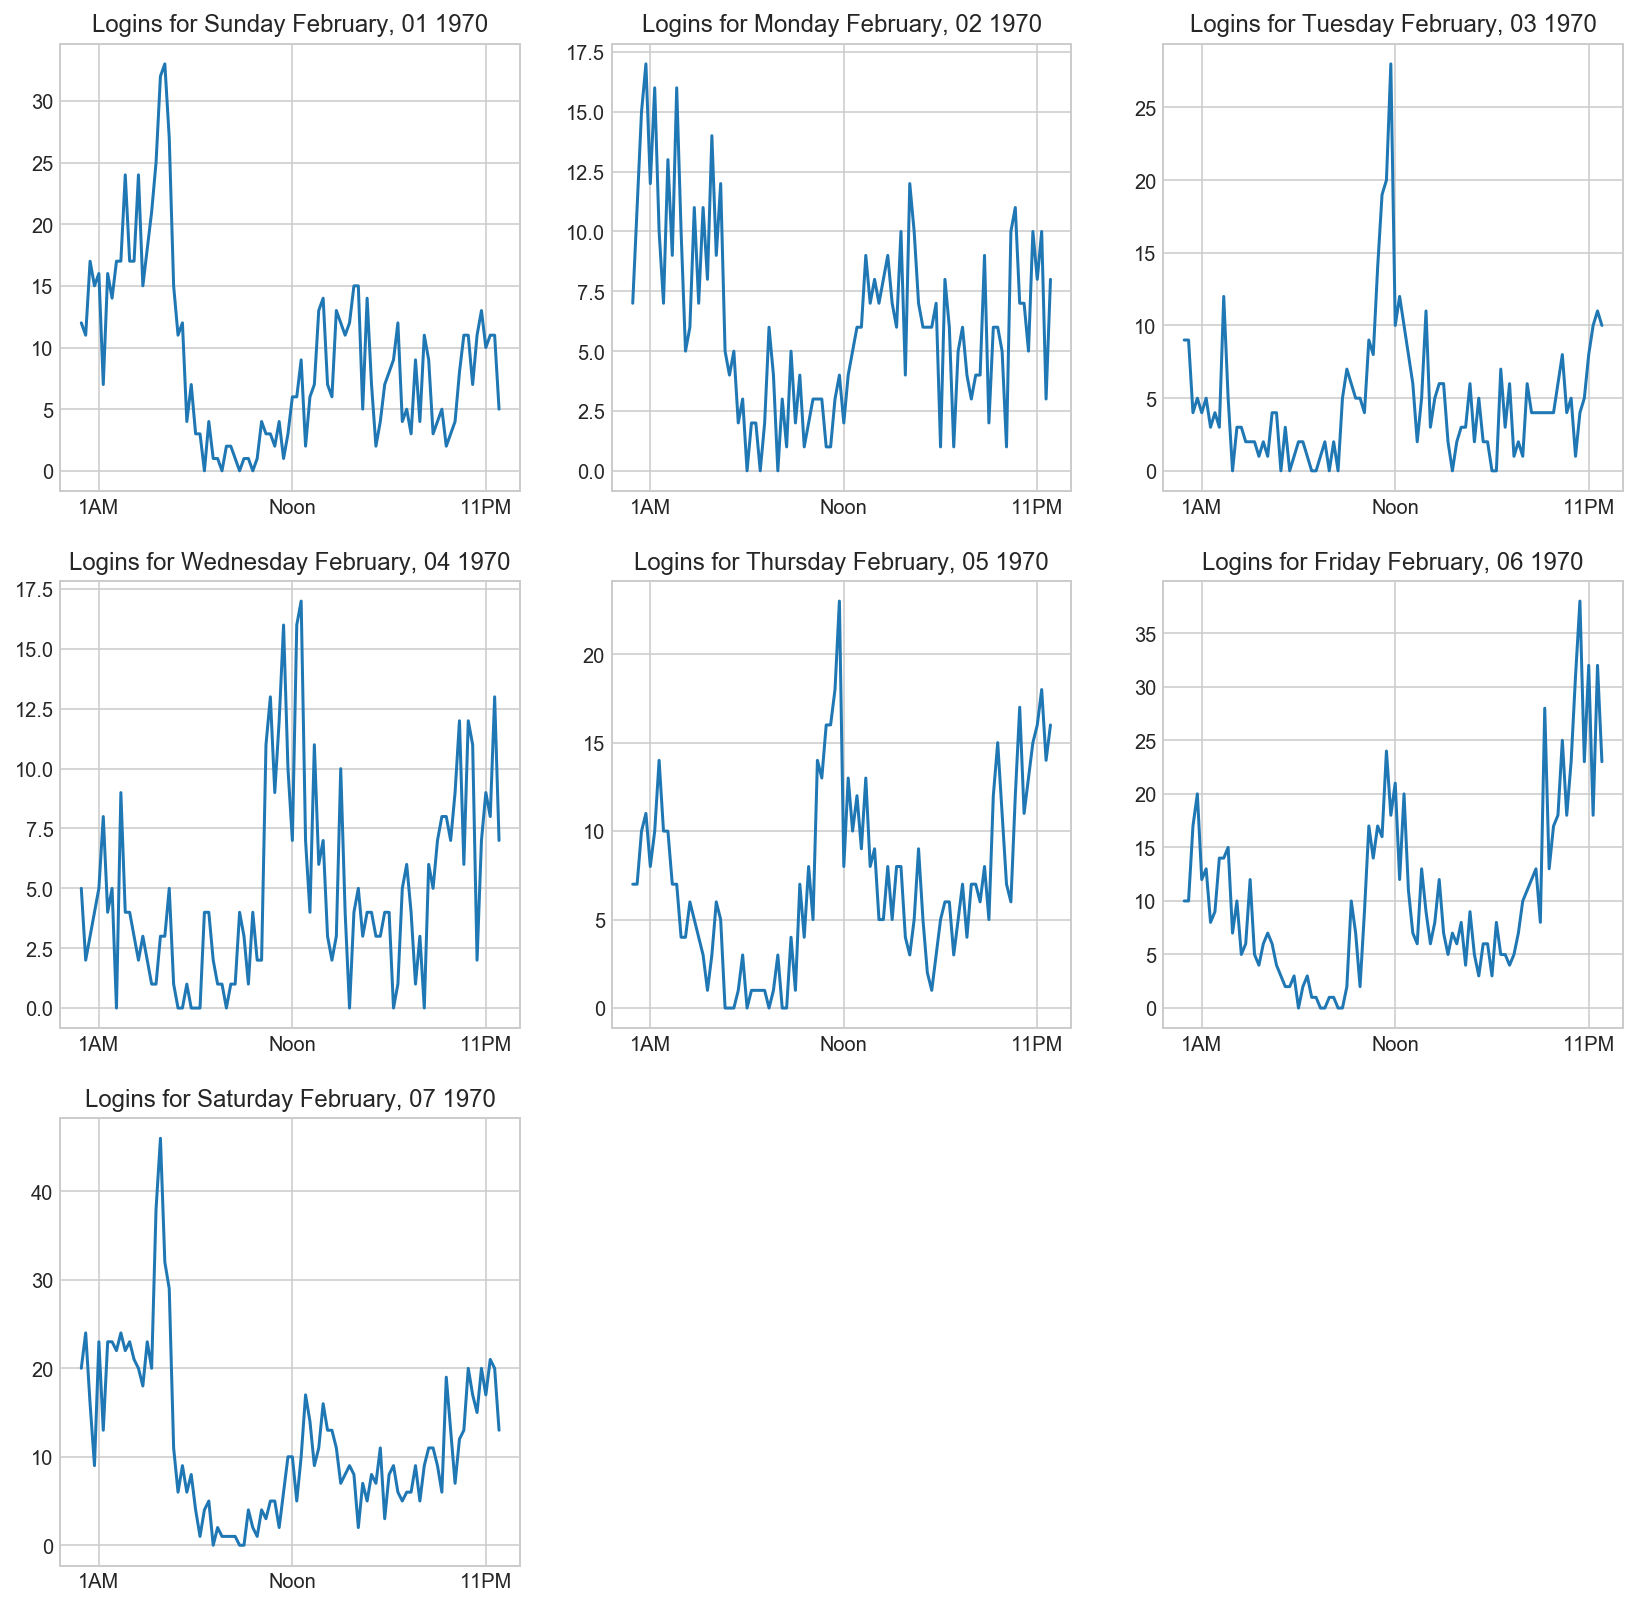

In [16]:
plot_one_week('1970-02-01')

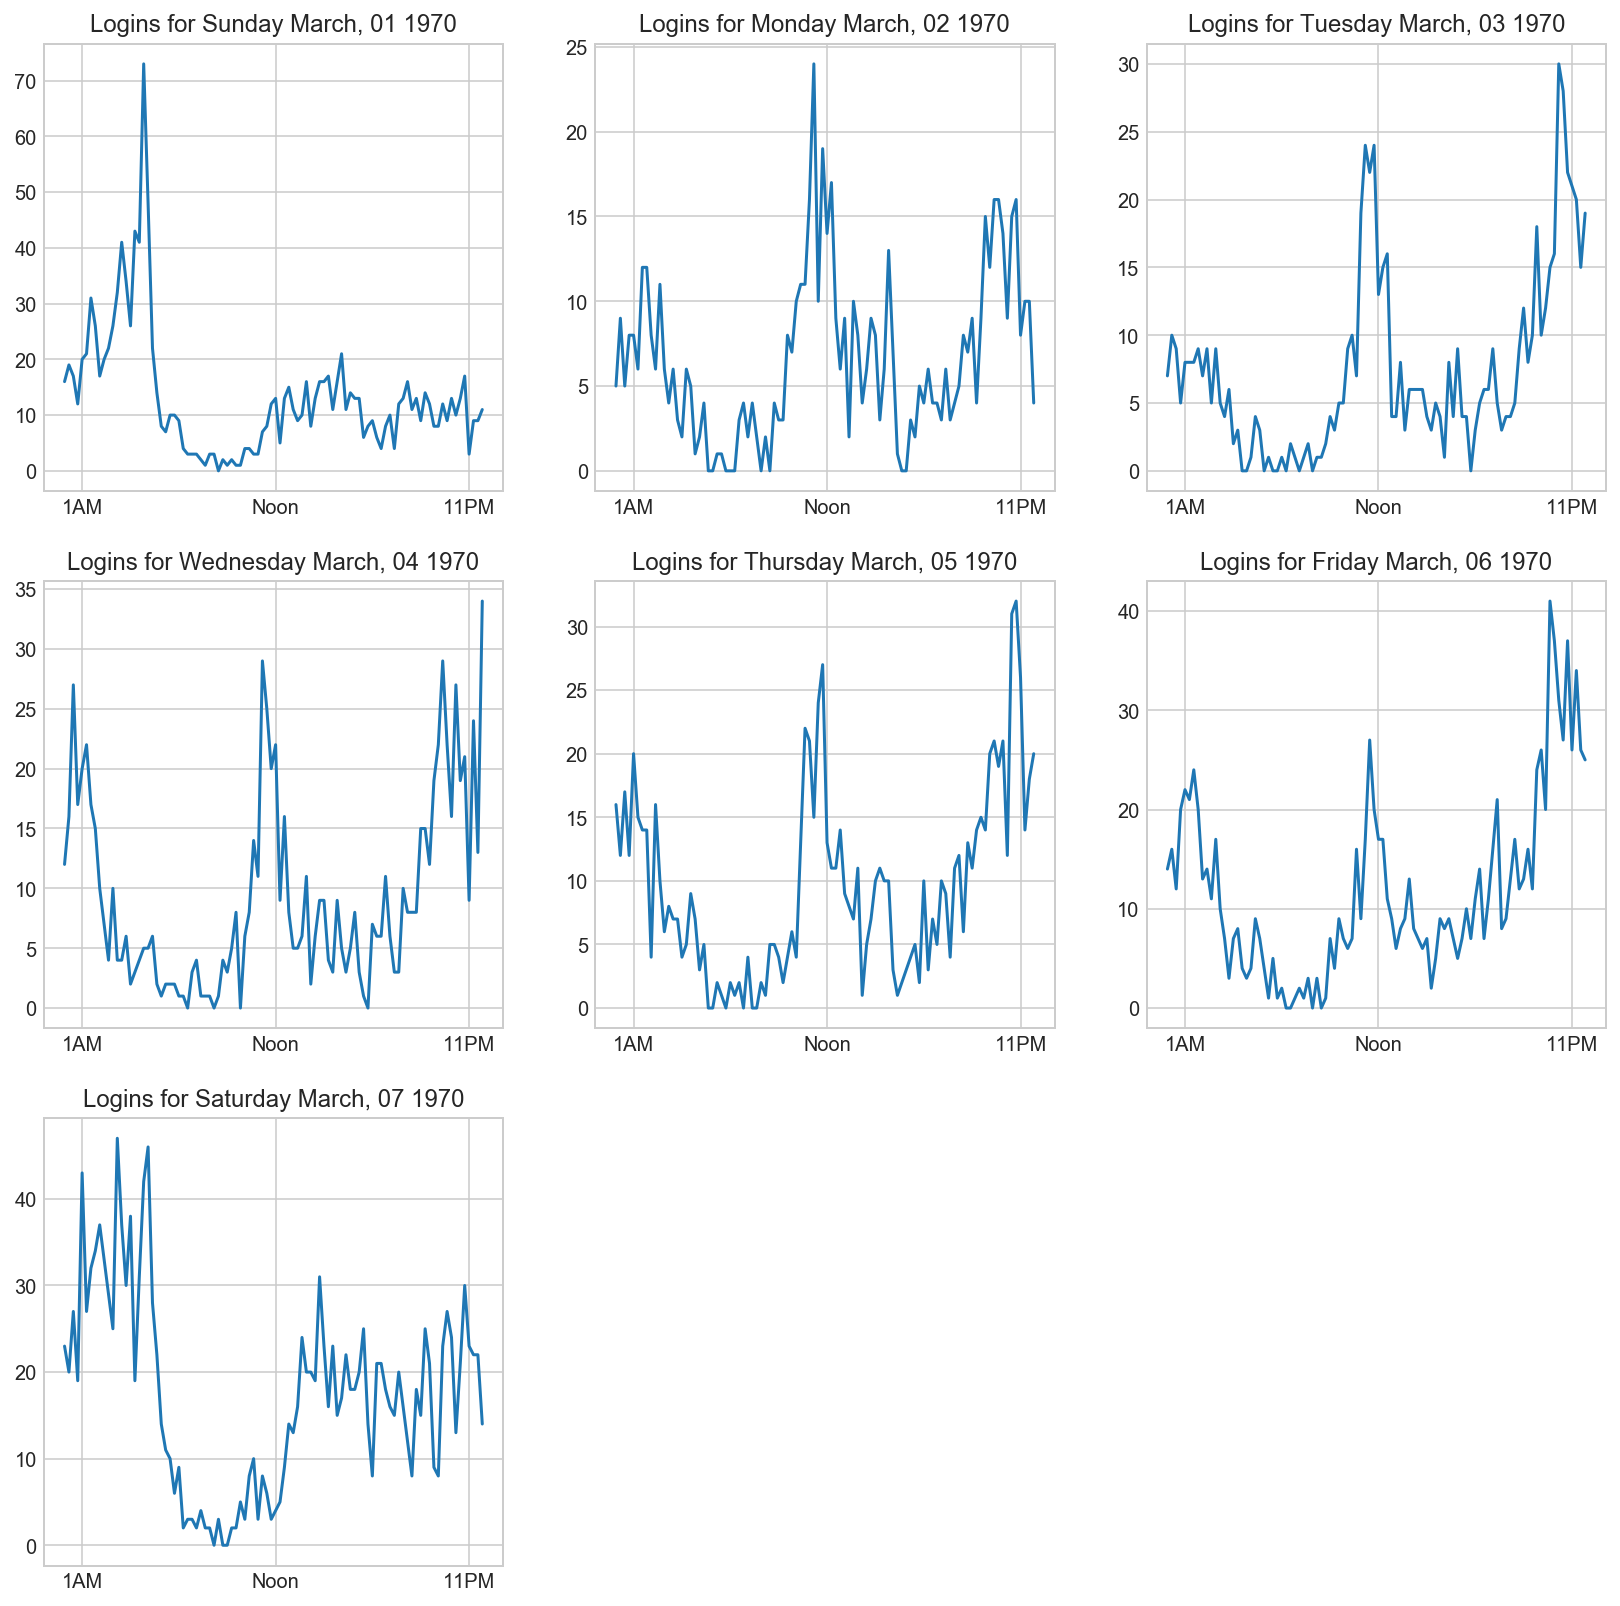

In [17]:
plot_one_week('1970-03-01')

# Daily Cycle Analysis
Looking at the `plot_one_week` function output, we can see that there is a realiable spike in logins around the noon hour. This is further verified through the hourly averages for weekdays and weekends. As working riders are presumably requiring transportation during their lunch breaks. On the weekends we can see more realiable spikes in the early morning as users are presumably finding transportation home after a night out. These weekend spikes tend to begin early Friday evening and decline early Monday morning.

****
# PART 2
## Experiment and metrics design
****

![experiment](experiment.png)

- Assuming that the surge in rider requests warrants the need for more drivers, we can assume that drivers would cross the bridge to maximize ridership.
# Metric of choice
- The metric I would use to assess the success of the toll reimbursement would be **total revenue/rides**. As calculated by:
#### $$\frac{\text{income from rider charges} - (\text{expenses} + \text{toll reimbursements})}{\text{total number of rides}} = \text{total revenue / rides}$$
- As the number of rides increases there will be a penalty on total revenue if too many of the drivers are crossing the bridge and not from the local pool of driver. However, if drivers are not crossing the bridge there are potentially greater number of rides that are dropped or never fulfilled.
- This metric should allow us to look at the metric over time because it will not be significantly influenced by yearly population increase or other external factors.
# Statistical Test
- The hypothesis we will assume is the null hypothesis; there is no effect on _total revenue/rides_ after introducing the toll reimbursement.
- The alternate hypothesis is that introducing a toll reimbursement program has a significant positive effect on _total revenue/rides_
    1. To implement the experiment, I will pull historical _total revenue/rides_ data to match seasonal demands and trends in the experimental dataset. I will then grant/track the toll reimbursement to inform the new metric.
    2. I will use the [Difference in differences](https://en.wikipedia.org/wiki/Difference_in_differences) technique to verify statistically that we can accept the alternate hypothesis; that the toll reimbursement has had a significant positive influence on total revenue.
    3. If we are able to regect the null hypothesis within an agreed upon confidence interval, I would suggest to management that they continue the reimbursement program because it represents a significant increase in total revenue. If our tests show that there is no significant change after introducing the program it would be my recommendation to cancel the program and investigate the influence of fuel costs, increased bridge congestion, and driver fatigue.

****
# PART 3
## Predictive Modeling
****

In [30]:
import json

file = open('ultimate_data_challenge.json', 'r')
file_content=file.read()
file.close()
data = json.loads(file_content)
df = pd.DataFrame(data)

# Handling NaNs
- I will substitute the missing **ratings** with the mean rating for that variable.
- I will do a simple forward fill to impute the missing phone records.

In [35]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()

In [42]:
num_columns = ['avg_rating_by_driver', 
              'avg_rating_of_driver', 
              'avg_dist', 'avg_surge', 
              'surge_pct', 
              'trips_in_first_30_days', 
              'weekday_pct']

imputer.fit(df.loc[:, num_columns])

SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)

In [46]:
cleaned = imputer.transform(df.loc[:, num_columns])

In [49]:
df_cleaned = pd.DataFrame(cleaned)
df_cleaned.columns = num_columns
df_cleaned.describe()

,avg_rating_by_driver,avg_rating_of_driver,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,4.778158,4.601559,5.796827,1.074764,8.849536,2.278200,60.926084
std,0.445753,0.564977,5.707357,0.222336,19.958811,3.792684,37.081503
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,4.700000,4.500000,2.420000,1.000000,0.000000,0.000000,33.300000
50%,5.000000,4.700000,3.880000,1.000000,0.000000,1.000000,66.700000
75%,5.000000,5.000000,6.940000,1.050000,8.600000,3.000000,100.000000
max,5.000000,5.000000,160.960000,8.000000,100.000000,125.000000,100.000000


In [58]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [63]:
df_dates = df.loc[:, ['signup_date', 'last_trip_date']]

In [85]:
df_objects = df.loc[:, ['phone', 'city', 'ultimate_black_user']]

In [110]:
df_objects['phone'].replace(pd.np.nan, 'Other', inplace=True)

In [86]:
from sklearn.preprocessing import OneHotEncoder

In [113]:
ohe = OneHotEncoder()
ohe.fit(df_objects)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [117]:
cleaned = ohe.transform(df_objects).toarray()

In [126]:
df_obj_cleaned = pd.DataFrame(cleaned)
df_obj_cleaned.columns = ohe.get_feature_names()
df_obj_cleaned.drop(['x0_Other', 'x1_Astapor', 'x2_False'],axis=1, inplace=True)

In [127]:
df_obj_cleaned.head()

,x0_Android,x0_iPhone,x1_King's Landing,x1_Winterfell,x2_True
0,0.0,1.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0


In [129]:
merged = df_cleaned.merge(df_dates, how='inner', left_index=True, right_index=True)
ml_df_cleaned = merged.merge(df_obj_cleaned, how='inner', left_index=True, right_index=True)

In [131]:
ml_df_cleaned.to_csv('cleaned_ml.csv')

In [133]:
!ls -al

total 45616
drwxr-xr-x@ 11 codyschellenberger  staff       352 22 Dec 20:30 .
drwxr-xr-x  19 codyschellenberger  staff       608 21 Dec 15:54 ..
-rw-r--r--@  1 codyschellenberger  staff      6148 20 Dec 16:16 .DS_Store
drwxr-xr-x   3 codyschellenberger  staff        96 20 Dec 11:54 .ipynb_checkpoints
-rw-r--r--   1 codyschellenberger  staff    820262 22 Dec 20:30 Login Timeseries Analysis.ipynb
-rw-r--r--   1 codyschellenberger  staff   4044252 22 Dec 00:15 cleaned_ml.csv
-rw-r--r--@  1 codyschellenberger  staff     33353 20 Dec 15:27 experiment.png
-rw-r--r--@  1 codyschellenberger  staff   2142282  6 Dec  2016 logins.json
-rw-r--r--@  1 codyschellenberger  staff      2082 21 Dec 22:43 test_file.json
-rw-r--r--@  1 codyschellenberger  staff  14824348 21 Dec 22:28 ultimate_data_challenge.json
-rw-------@  1 codyschellenberger  staff    146975  6 Dec  2016 ultimate_data_science_challenge.pdf


In [155]:
ml_df_cleaned.head()

,avg_rating_by_driver,avg_rating_of_driver,avg_dist,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,signup_date,last_trip_date,x0_Android,x0_iPhone,x1_King's Landing,x1_Winterfell,x2_True
0,5.0,4.7,3.67,1.10,15.4,4.0,46.2,2014-01-25,2014-06-17,0.0,1.0,1.0,0.0,1.0
1,5.0,5.0,8.26,1.00,0.0,0.0,50.0,2014-01-29,2014-05-05,1.0,0.0,0.0,0.0,0.0
2,5.0,4.3,0.77,1.00,0.0,3.0,100.0,2014-01-06,2014-01-07,0.0,1.0,0.0,0.0,0.0
3,4.9,4.6,2.36,1.14,20.0,9.0,80.0,2014-01-10,2014-06-29,0.0,1.0,1.0,0.0,1.0
4,4.9,4.4,3.13,1.19,11.8,14.0,82.4,2014-01-27,2014-03-15,1.0,0.0,0.0,1.0,0.0


In [144]:
y = ml_df_cleaned['trips_in_first_30_days'] > 0

In [145]:
y = pd.Series([int(x) for x in y])

In [185]:
feats = ml_df_cleaned.drop(['trips_in_first_30_days', 'signup_date', 'last_trip_date'], axis=1)

In [186]:
X = feats.values

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [163]:
logit = LogisticRegression(solver='newton-cg', max_iter=1000)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [164]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [167]:
prob = logit.predict_proba(X_test)

In [168]:
df_proba = pd.DataFrame(prob)

In [169]:
actual = pd.DataFrame(y_test)

In [170]:
df_prediction = df_proba.merge(actual, left_index=True, right_index=True)

In [172]:
from sklearn.ensemble import RandomForestClassifier

In [173]:
clf = RandomForestClassifier(n_estimators=1000)

In [174]:
clf.fit(X_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [175]:
clf_proba = clf.predict_proba(X_test)
df_clf_proba = pd.DataFrame(clf_proba)

In [212]:
df_clf_prediciton = df_clf_proba.merge(actual, left_index=True, right_index=True)
df_clf_prediciton.head(1)

,0_x,1,0_y
1,0.45976,0.54024,0


In [178]:
clf.feature_importances_

array([0.07735022, 0.09179281, 0.55361068, 0.04907723, 0.04574631,
       0.10703275, 0.00981419, 0.01053138, 0.01529726, 0.01777491,
       0.02197226])

In [200]:
feat_import = zip(clf.feature_importances_, np.array(feats.columns))

In [201]:
feat_list = list(feat_import)

In [207]:
feat_list.sort(reverse=True)

In [208]:
feat_list

[(0.5536106753838926, 'avg_dist'),
 (0.10703275399590073, 'weekday_pct'),
 (0.09179281082474001, 'avg_rating_of_driver'),
 (0.07735021805307675, 'avg_rating_by_driver'),
 (0.049077230768264965, 'avg_surge'),
 (0.04574631383742014, 'surge_pct'),
 (0.02197226456924131, 'x2_True'),
 (0.017774906334679097, 'x1_Winterfell'),
 (0.015297262386336757, "x1_King's Landing"),
 (0.010531378331057224, 'x0_iPhone'),
 (0.009814185515390449, 'x0_Android')]

## The key indicators of my retention prediction model are:
- The average distance travelled `avg_dist` with a feature importance of 0.55
- The weekday percentage `weekday_pct` with a feature importance of 0.11
- The averge rating of driver `avg_rating_of_driver` with a feature importance of 0.09

In [211]:
from sklearn.metrics import confusion_matrix

In [213]:
y_pred = clf.predict(X_test)

In [214]:
confusion_matrix(y_test, y_pred)

array([[ 4611,    56],
       [   42, 10291]])

![confusionMatrix](https://revolution-computing.typepad.com/.a/6a010534b1db25970b01bb08c97955970d-200wi)

# Model Analysis
The model is accurately identifying the retention of users based on logins within the first 30 days. Based on the feature importance I would recommend that the company look at incentivising riders based on distance travelled and the percentage of rides taken during weekdays.